# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [73]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [74]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [75]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.head()

(69, 6)


,title,price,year,link,brand,age
0,2022 honda civic sport sedan,18500,2022.0,https://charlottesville.craigslist.org/cto/d/c...,honda,3.0
1,honda fit ex-l 2016 low miles,9000,2016.0,https://charlottesville.craigslist.org/cto/d/c...,honda,9.0
2,"2012 kia soul only 55,000 miles",6700,2012.0,https://charlottesville.craigslist.org/cto/d/l...,kia,13.0
3,2003 honda crv,2500,2003.0,https://charlottesville.craigslist.org/cto/d/c...,honda,22.0
4,2008 chevy hhr lt,10800,2008.0,https://charlottesville.craigslist.org/cto/d/s...,chevy,17.0


With the data in and wrangled, we can now do some analysis:

count       69.000000
mean      9989.057971
std      10516.706636
min       2000.000000
25%       3400.000000
50%       6500.000000
75%      11500.000000
max      62800.000000
Name: price, dtype: float64


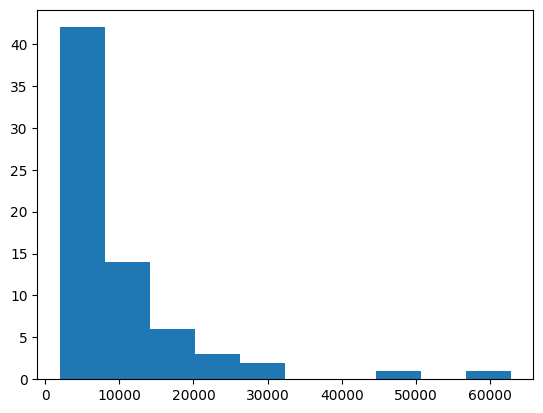

count    63.000000
mean     21.777778
std      14.625921
min       3.000000
25%      13.000000
50%      18.000000
75%      23.000000
max      68.000000
Name: age, dtype: float64


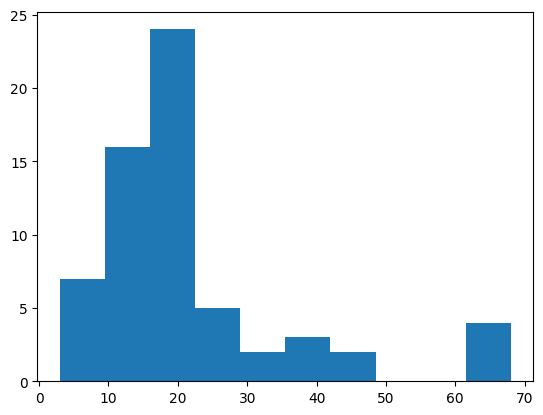

In [76]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [77]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          3.0   9333.333333   1607.275127   7500.0   8750.0  10000.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    4.0  16362.500000   9061.399358   4950.0  12112.5  17000.0   
chevy        5.0   4980.000000   3566.791275   2200.0   2900.0   3000.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         6.0  18833.333333  15980.196077   4000.0  10500.0  15750.0   
gmc          3.0  12250.000000  12018.215342   3750.0   5375.0   7000.0   
honda       13.0   9246.153846   7714.014885   2500.0   3400.0   6500.0   
jeep         1.0   6250.000000           NaN   6250.0   6250.0   6250.0   
kia          2.0   4600.000000   2969.848481   2500.0   3550.0   4600.0   
lexus        1.0   3896.000000           NaN   3896.0   3896.0   3896.0   
missing     13.0  10096.153846  16937.968463   2000.0   3200.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   5999.000000           NaN   5999.0   5999.0   5999.0   
tesla        1.0  25000.000000           NaN  25000.0  25000.0  25000.0   
toyota       6.0   8558.333333   4654.290136   3000.0   5525.0   8225.0   
volkswagen   3.0   7666.666667   5788.854233   2550.0   4525.0   6500.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw         10250.0  10500.0  
cadillac     2950.0   2950.0  
chevrolet   21250.0  26500.0  
chevy        6000.0  10800.0  
dodge        8312.5   9750.0  
ford        18375.0  49500.0  
gmc         16500.0  26000.0  
honda       13000.0  29000.0  
jeep         6250.0   6250.0  
kia          5650.0   6700.0  
lexus        3896.0   3896.0  
missing      5250.0  62800.0  
mitsubishi   6800.0   6800.0  
subaru       5999.0   5999.0  
tesla       25000.0  25000.0  
toyota      10512.5  16000.0  
volkswagen  10225.0  13950.0

In [78]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.50  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    4.0  41.250000  19.619293  21.0  32.25  38.0  47.00  68.0
chevy        3.0  21.333333   4.509250  17.0  19.00  21.0  23.50  26.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         6.0  19.666667   7.941452  11.0  14.00  19.5  22.00  33.0
gmc          2.0  30.500000  14.849242  20.0  25.25  30.5  35.75  41.0
honda       13.0  13.230769   6.482719   3.0   9.00  13.0  16.00  25.0
jeep         1.0  13.000000        NaN  13.0  13.00  13.0  13.00  13.0
kia          2.0  15.000000   2.828427  13.0  14.00  15.0  16.00  17.0
lexus        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
missing     10.0  35.100000  22.859231   7.0  18.75  26.0  58.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       6.0  18.333333   4.885352  12.0  14.75  19.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

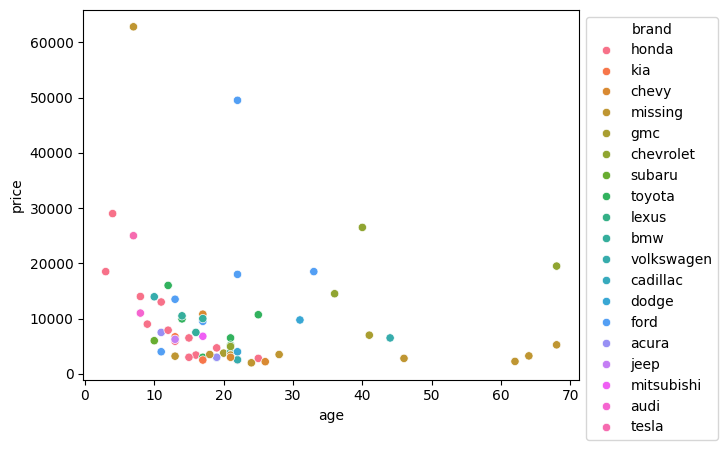

In [79]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.654993 -0.170373
log_age    -0.170373  0.376932
           log_price   log_age
log_price   1.000000 -0.346185
log_age    -0.346185  1.000000


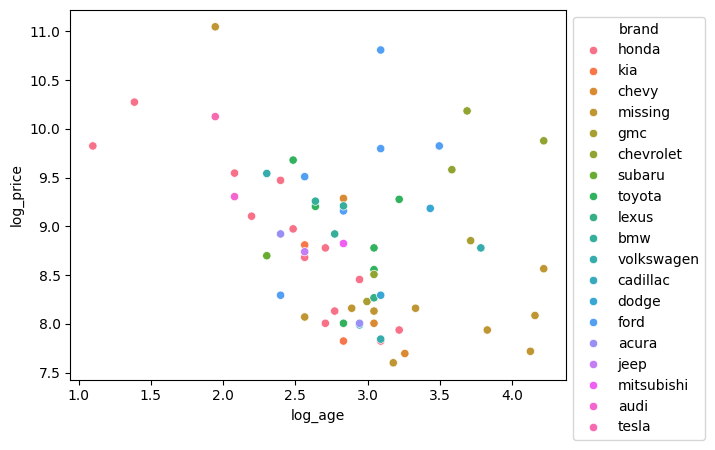

In [80]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.

I will look at Musical instruments on Craigslist. The data I would like to gather is: year, price, instrument type.

2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup as soup # HTML parser
import requests # Page requests
import re # Regular expressions
import time # Time delays
import random # Random numbers

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/msa?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

instrumentTypes = ["guitar", "piano", "drum", "clarinet", "flute", "ukulele", "microphone","speaker", "banjo", "epiphone", "trumpet", "cymbals", "viola", "bass"]

In [82]:
data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get instrument type from the title string:
    words = title.split()
    hits = [word for word in words if word in instrumentTypes] # Find instrument type in the title
    if len(hits) == 0:
        instrumentType = 'missing'
    else:
        instrumentType = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'instrument type':instrumentType})

In [83]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.head()

(124, 6)


,title,price,year,link,instrument type,age
0,martin d35 sunburst with fishman pickup,2800,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
1,"yamaha dtxpress iv electronic drum kit, simmon...",700,NaN,https://charlottesville.craigslist.org/msg/d/c...,drum,NaN
2,"british drum company merlin 14x6.5"" 10-lug map...",525,NaN,https://charlottesville.craigslist.org/msg/d/c...,drum,NaN
3,gibson les paul standard '60s plain top pelham...,2100,NaN,https://charlottesville.craigslist.org/msg/d/c...,guitar,NaN
4,taylor builder's edition 814ce acoustic/electr...,3200,NaN,https://charlottesville.craigslist.org/msg/d/c...,guitar,NaN


count     124.000000
mean      484.798387
std       759.186953
min         0.000000
25%        50.000000
50%       175.000000
75%       612.500000
max      5000.000000
Name: price, dtype: float64


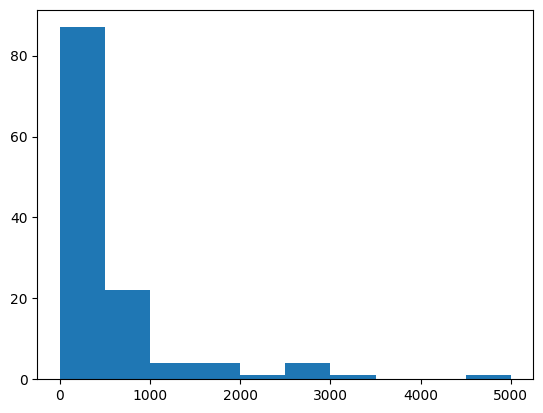

count    16.000000
mean     41.750000
std      14.252485
min       7.000000
25%      38.000000
50%      45.500000
75%      49.250000
max      63.000000
Name: age, dtype: float64


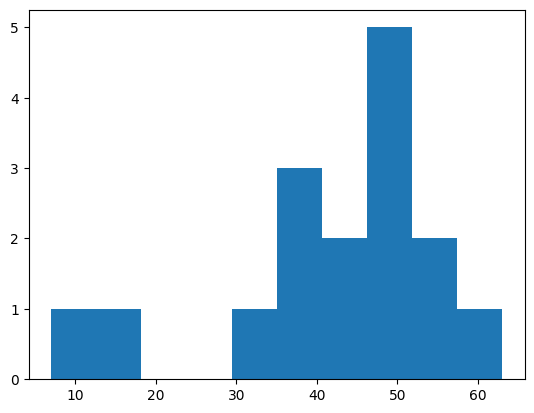

In [84]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [85]:
# Price by instrument type:
df.loc[:,['price','instrument type']].groupby('instrument type').describe()

price                                                  \
                count         mean          std    min     25%    50%   
instrument type                                                         
banjo             1.0   375.000000          NaN  375.0  375.00  375.0   
bass              7.0   205.000000   274.104603   35.0   50.00   75.0   
cymbals           1.0   200.000000          NaN  200.0  200.00  200.0   
drum              6.0  1491.666667  1933.821777   50.0  262.50  612.5   
epiphone          2.0   487.500000    17.677670  475.0  481.25  487.5   
guitar           22.0   459.409091   822.248234    0.0   12.75   80.0   
microphone        2.0   167.500000   130.814755   75.0  121.25  167.5   
missing          74.0   503.621622   628.619660    1.0   86.25  299.5   
piano             2.0    75.000000   106.066017    0.0   37.50   75.0   
trumpet           1.0   100.000000          NaN  100.0  100.00  100.0   
ukulele           5.0    14.000000     8.944272    5.0    5.00   15.0   
viola             1.0   150.000000          NaN  150.0  150.00  150.0   

                                  
                     75%     max  
instrument type                   
banjo             375.00   375.0  
bass              212.50   800.0  
cymbals           200.00   200.0  
drum             2050.00  5000.0  
epiphone          493.75   500.0  
guitar            387.50  3200.0  
microphone        213.75   260.0  
missing           731.25  2800.0  
piano             112.50   150.0  
trumpet           100.00   100.0  
ukulele            20.00    25.0  
viola             150.00   150.0

In [86]:
# Age by instrument type:
df.loc[:,['age','instrument type']].groupby('instrument type').describe()
# This is not very helpful, as most age data is missing (year not included in listing)

age                                                     
                count       mean        std   min   25%   50%    75%   max
instrument type                                                           
banjo             1.0  55.000000        NaN  55.0  55.0  55.0  55.00  55.0
bass              0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
cymbals           0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
drum              0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
epiphone          1.0  16.000000        NaN  16.0  16.0  16.0  16.00  16.0
guitar            2.0  35.000000   5.656854  31.0  33.0  35.0  37.00  39.0
microphone        0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
missing          12.0  43.916667  13.581125   7.0  42.0  47.5  49.25  63.0
piano             0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
trumpet           0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
ukulele           0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN
viola             0.0        NaN        NaN   NaN   NaN   NaN    NaN   NaN

<Axes: xlabel='instrument type', ylabel='price'>

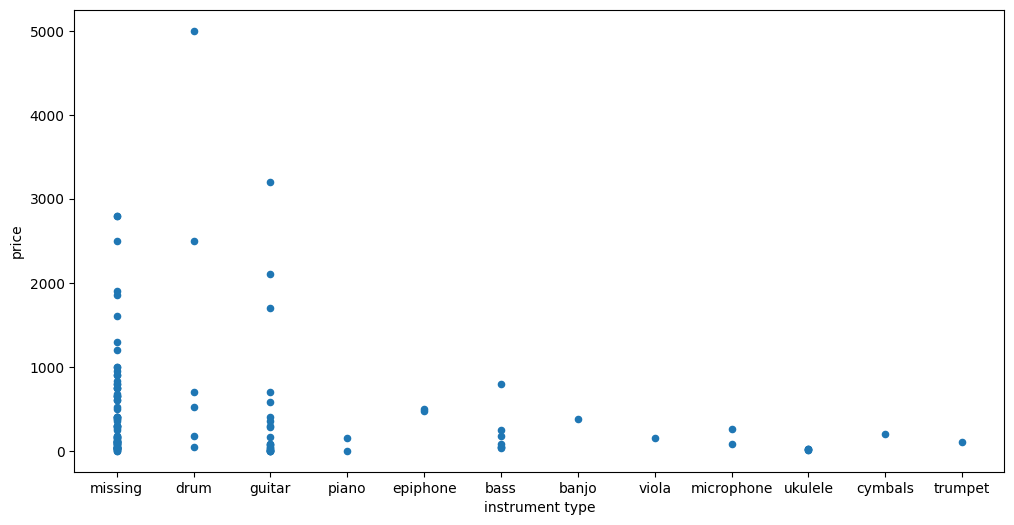

In [91]:
df.plot.scatter('instrument type','price', figsize=(12,6))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='instrument type', ylabel='log_price'>

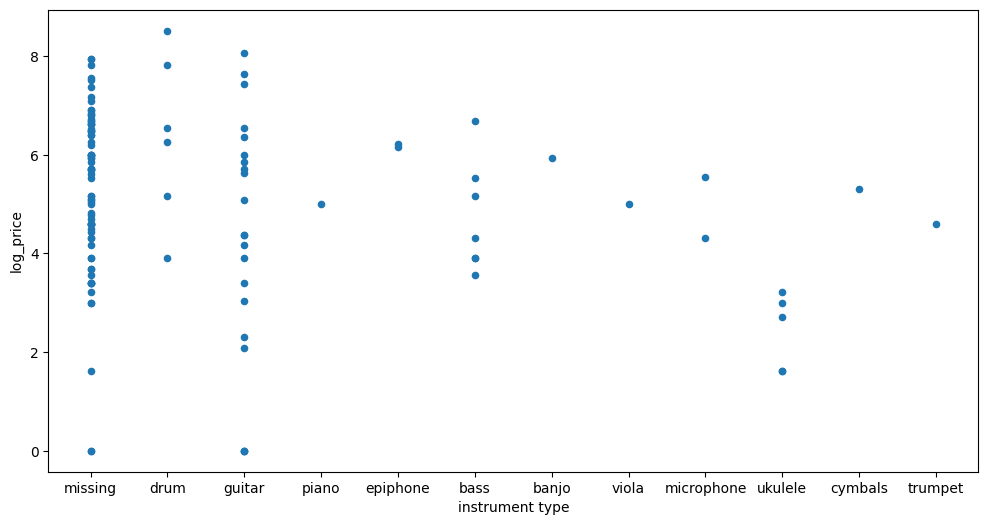

In [94]:
df["log_price"] = np.log(df['price'])
df.plot.scatter('instrument type','log_price', figsize=(12,6))
# The price of drums and guitar tend to be higher than the price of other instruments, but also the range of prices for these instruments is much greater (greater variability).
# It was difficult to wrangle this data given how many non-musical instruments or un-informative titles were in the listings.
# Given the number of observations for each instrument type, guitars are a very frequently listed instrument.
# There are upper outliers in terms of price for some instruments. This could indicate luxury or vintage instruments.